# Deep learning application in medical images recognition - *Optical Coherence Tomography classification*
# 1. Introduction
Artificial intelligence has the potential to revolutionize disease diagnosis and management by performing classification difficult for human experts and by rapidly reviewing immense amounts of images. Despite its potential, clinical interpretability and feasible preparation of AI remains challenging.

Compared to the traditional and old algorithmic approach for image analysis and classification, the development of convolutional neural network (CNN) layers has allowed for significant gains in the ability to classify images and detect objects in a picture (Krizhevsky et al., 2017; Zeiler and Fergus, 2014). These are multiple processing layers to which image analysis filters, or convolutions, are applied. The abstracted representation of images within each layer is constructed by systematically convolving multiple filters across the image, producing a feature map that is used as input to the following layer. This architecture makes it possible to process images in the form of pixels as input and to give the desiredclassification as output. 

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

Optical coherence tomography (OCT) is a non-invasive imaging test. OCT uses light waves to take cross-section pictures of your retina.

With OCT, your ophthalmologist can see each of the retina’s distinctive layers. This allows your ophthalmologist to map and measure their thickness. These measurements help with diagnosis. They also provide treatment guidance for glaucoma and diseases of the retina. These retinal diseases include age-related macular degeneration (AMD) and diabetic eye disease.

# 1.1. Packages Import
In the following lines of code I import all the useful packages and libreries that will result useful throughout the whole project. More specifically, for the deep learning analysis, I will develop the convolutional neural network using both Tensorflow and Keras libreries.

In [3]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
from os import listdir
from os.path import isfile, join

import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries

import seaborn as sns
from PIL import Image
import glob
import cv2

np.random.seed(30535)
%matplotlib inline

# 1.2. Data Reading
We now read the data, accessing the images in their relative folder, setting the paths to do so. 

More specifically, the dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).

Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

*Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.*

*Before training, each image went through a tiered grading system consisting of multiple layers of trained graders of increasing exper- tise for verification and correction of image labels. Each image imported into the database started with a label matching the most recent diagnosis of the patient. The first tier of graders consisted of undergraduate and medical students who had taken and passed an OCT interpretation course review. This first tier of graders conducted initial quality control and excluded OCT images containing severe artifacts or significant image resolution reductions. The second tier of graders consisted of four ophthalmologists who independently graded each image that had passed the first tier. The presence or absence of choroidal neovascularization (active or in the form of subretinal fibrosis), macular edema, drusen, and other pathologies visible on the OCT scan were recorded. Finally, a third tier of two senior independent retinal specialists, each with over 20 years of clinical retina experience, verified the true labels for each image. The dataset selection and stratification process is displayed in a CONSORT-style diagram in Figure 2B. To account for human error in grading, a validation subset of 993 scans was graded separately by two ophthalmologist graders, with disagreement in clinical labels arbitrated by a senior retinal specialist.*




The dataset is divided in three categories: training, validation and test.

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

Note: These three sets should all contain different images.

In [4]:
dirname = '/kaggle/input'
train_path = os.path.join(dirname, 'kermany2018/OCT2017 /train')
train_normal_path = os.path.join(train_path, 'NORMAL')
train_dme_path = os.path.join(train_path, 'DME')
train_drusen_path = os.path.join(train_path, 'DRUSEN')
train_cnv_path = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'kermany2018/OCT2017 /test')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_dme_path = os.path.join(test_path, 'DME')
test_drusen_path = os.path.join(test_path, 'DRUSEN')
test_cnv_path = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'kermany2018/OCT2017 /val')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_dme_path = os.path.join(val_path, 'DME')
val_drusen_path = os.path.join(val_path, 'DRUSEN')
val_cnv_path = os.path.join(val_path, 'CNV')

# 1.3. Data Visualization
For the sake of having a better understanding of the dataset, I define a help function which is useful for plotting some images for each class.

In [5]:
def plot_img(item_dir, num_imgs=6):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(item_files):
        plt.subplot(1, 6, i+1)

        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

# 1.3.1. Normal
Normal retina with preserved foveal contour and absence of any retinal fluid/edema.



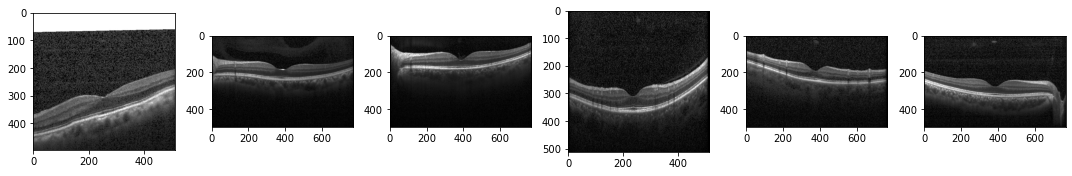

In [6]:
plot_img(train_normal_path)

# 1.3.2. DME
Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid. 

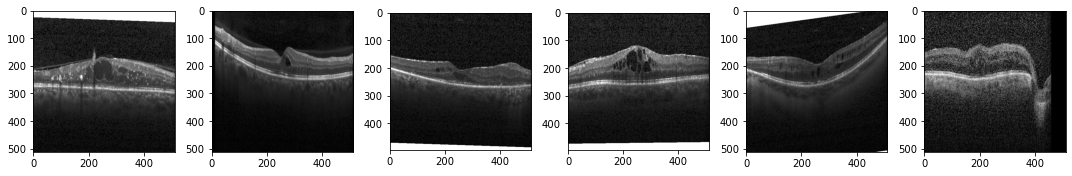

In [7]:
plot_img(train_dme_path)

# 1.3.3. Drusen
Multiple drusen present in early AMD.

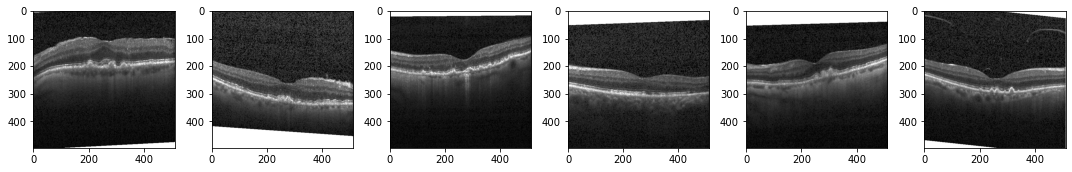

In [8]:
plot_img(train_drusen_path)

# 1.3.4. CNV
choroidal neovascularization (CNV) with neovascular membrane and associated subretinal fluid. 

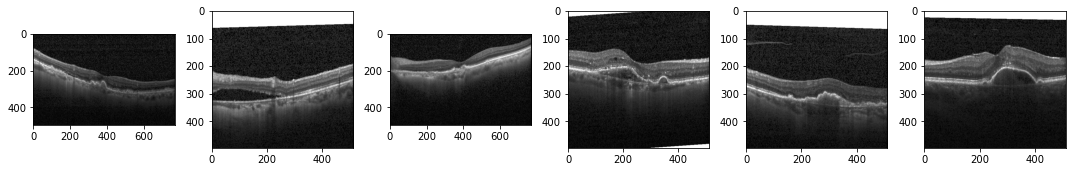

In [9]:
plot_img(train_cnv_path)

# 2. Model Deployment

# 2.1. Data Augmentation

ImageDataGenerator is the function used in Keras for the data augmentation, train_datagen is used to apply data augmentation, randomly translating, rotating, resizing, etc. images on the fly. Performing data augmentation is a form of regularization, enabling our model to generalize better. However, applying data augmentation implies that our training data is no longer “static", the data is constantly changing. Each new batch of data is randomly adjusted according to the parameters supplied to ImageDataGenerator.

1. Keras calls the generator function supplied to .fit_generator.
2. The generator function yields a batch of size BS  to the .fit_generator  function.
3. The .fit_generator  function accepts the batch of data, performs backpropagation, and updates the weights in our model.
4. This process is repeated until we have reached the desired number of epochs.

In [10]:
def process_data(img_dims, batch_size):
    
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.3,horizontal_flip = True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(directory=train_path, target_size=(img_dims, img_dims), 
                                                  batch_size=batch_size, class_mode='categorical', shuffle=True)
    
    test_gen = test_datagen.flow_from_directory(directory=test_path, target_size=(img_dims, img_dims), 
                                                batch_size=batch_size, class_mode='categorical', shuffle=True)
    
    # Creating the dataset which will be used for the LIME 
    #train_gen1 = train_datagen.flow_from_directory(directory=train_path, target_size=(img_dims, img_dims), 
                                              #batch_size=83488, class_mode='categorical')
    
    train_gen2 = test_datagen.flow_from_directory(directory=test_path, target_size=(img_dims, img_dims), 
                                              batch_size=test_gen.samples, class_mode='categorical')

    #X_train, y_train = train_gen1.next()
    X_test, y_test = train_gen2.next()
    
    #return train_gen, test_gen, X_train, y_train, X_test, y_test
    return train_gen, test_gen, X_test, y_test

# 2.2. Parameters Setting
TODO Spiegazione dei vari parametri usati 

1. img_dims': 128,
2. 'epochs': 10,
3. 'batch_size': 32,
4. 'optimizer': 'adam',
5. 'loss': 'categorical_crossentropy',
6. 'metrics': 'accuracy'

In [11]:
PARAMS = {'img_dims': 128,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy'
          }

# 2.3. Model Training

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with loss.backward() and optimizer.step(). Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). The accuracy will tell us how many predictions were correct.

TODO spiegazione di quello che succede nella rete neurale

Some theory about Spatial Separable Convolutions.

Conceptually, this is the easier one out of the two, and illustrates the idea of separating one convolution into two well, so I’ll start with this. Unfortunately, spatial separable convolutions have some significant limitations, meaning that it is not heavily used in deep learning.

The spatial separable convolution is so named because it deals primarily with the spatial dimensions of an image and kernel: the width and the height. (The other dimension, the “depth” dimension, is the number of channels of each image). A spatial separable convolution simply divides a kernel into two, smaller kernels.

The most common case would be to divide a 3x3 kernel into a 3x1 and 1x3 kernel, like so:

Now, instead of doing one convolution with 9 multiplications, we do two convolutions with 3 multiplications each (6 in total) to achieve the same effect. With less multiplications, computational complexity goes down, and the network is able to run faster.

One of the most famous convolutions that can be separated spatially is the Sobel kernel, used to detect edges:

The main issue with the spatial separable convolution is that not all kernels can be “separated” into two, smaller kernels. This becomes particularly bothersome during training, since of all the possible kernels the network could have adopted, it can only end up using one of the tiny portion that can be separated into two smaller kernels.

Depthwise Separable Convolutions

Unlike spatial separable convolutions, depthwise separable convolutions work with kernels that cannot be “factored” into two smaller kernels. Hence, it is more commonly used. This is the type of separable convolution seen in keras.layers.SeparableConv2D or tf.layers.separable_conv2d.

The depthwise separable convolution is so named because it deals not just with the spatial dimensions, but with the depth dimension — the number of channels — as well. An input image may have 3 channels: RGB. After a few convolutions, an image may have multiple channels. You can image each channel as a particular interpretation of that image; in for example, the “red” channel interprets the “redness” of each pixel, the “blue” channel interprets the “blueness” of each pixel, and the “green” channel interprets the “greenness” of each pixel. An image with 64 channels has 64 different interpretations of that image.

Similar to the spatial separable convolution, a depthwise separable convolution splits a kernel into 2 separate kernels that do two convolutions: the depthwise convolution and the pointwise convolution. But first of all, let’s see how a normal convolution works.

Normal Convolution:

If you don’t know how a convolution works from a 2-D perspective, read this article or check out this site. A typical image, however, is not 2-D; it also has depth as well as width and height. Let us assume that we have an input image of 12x12x3 pixels, an RGB image of size 12x12. Let’s do a 5x5 convolution on the image with no padding and a stride of 1. If we only consider the width and height of the image, the convolution process is kind of like this: 12x12 — (5x5) — >8x8. The 5x5 kernel undergoes scalar multiplication with every 25 pixels, giving out1 number every time. We end up with a 8x8 pixel image, since there is no padding (12–5+1 = 8).

However, because the image has 3 channels, our convolutional kernel needs to have 3 channels as well. This means, instead of doing 5x5=25 multiplications, we actually do 5x5x3=75 multiplications every time the kernel moves. Just like the 2-D interpretation, we do scalar matrix multiplication on every 25 pixels, outputting 1 number. After going through a 5x5x3 kernel, the 12x12x3 image will become a 8x8x1 image.

What if we want to increase the number of channels in our output image? What if we want an output of size 8x8x256? Well, we can create 256 kernels to create 256 8x8x1 images, then stack them up together to create a 8x8x256 image output.


his is how a normal convolution works. I like to think of it like a function: 12x12x3 — (5x5x3x256) — >12x12x256 (Where 5x5x3x256 represents the height, width, number of input channels, and number of output channels of the kernel). Not that this is not matrix multiplication; we’re not multiplying the whole image by the kernel, but moving the kernel through every part of the image and multiplying small parts of it separately.

A depthwise separable convolution separates this process into 2 parts: a depthwise convolution and a pointwise convolution.

Part 1 — Depthwise Convolution:

In the first part, depthwise convolution, we give the input image a convolution without changing the depth. We do so by using 3 kernels of shape 5x5x1.


Each 5x5x1 kernel iterates 1 channel of the image (note: 1 channel, not all channels), getting the scalar products of every 25 pixel group, giving out a 8x8x1 image. Stacking these images together creates a 8x8x3 image.

Part 2 — Pointwise Convolution:

Remember, the original convolution transformed a 12x12x3 image to a 8x8x256 image. Currently, the depthwise convolution has transformed the 12x12x3 image to a 8x8x3 image. Now, we need to increase the number of channels of each image.

The pointwise convolution is so named because it uses a 1x1 kernel, or a kernel that iterates through every single point. This kernel has a depth of however many channels the input image has; in our case, 3. Therefore, we iterate a 1x1x3 kernel through our 8x8x3 image, to get a 8x8x1 image.

We can create 256 1x1x3 kernels that output a 8x8x1 image each to get a final image of shape 8x8x256.

And that’s it! We’ve separated the convolution into 2: a depthwise convolution and a pointwise convolution. In a more abstract way, if the original convolution function is 12x12x3 — (5x5x3x256) →12x12x256, we can illustrate this new convolution as 12x12x3 — (5x5x1x1) — > (1x1x3x256) — >12x12x256.

Alright, but what’s the point of creating a depthwise separable convolution?

Let’s calculate the number of multiplications the computer has to do in the original convolution. There are 256 5x5x3 kernels that move 8x8 times. That’s 256x3x5x5x8x8=1,228,800 multiplications. What about the separable convolution? In the depthwise convolution, we have 3 5x5x1 kernels that move 8x8 times. That’s 3x5x5x8x8 = 4,800 multiplications. In the pointwise convolution, we have 256 1x1x3 kernels that move 8x8 times. That’s 256x1x1x3x8x8=49,152 multiplications. Adding them up together, that’s 53,952 multiplications.

52,952 is a lot less than 1,228,800. With less computations, the network is able to process more in a shorter amount of time.

How does that work, though? The first time I came across this explanation, it didn’t really make sense to me intuitively. Aren’t the two convolutions doing the same thing? In both cases, we pass the image through a 5x5 kernel, shrink it down to one channel, then expand it to 256 channels. How come one is more than twice as fast as the other?

After pondering about it for some time, I realized that the main difference is this: in the normal convolution, we are transforming the image 256 times. And every transformation uses up 5x5x3x8x8=4800 multiplications. In the separable convolution, we only really transform the image once — in the depthwise convolution. Then, we take the transformed image and simply elongate it to 256 channels. Without having to transform the image over and over again, we can save up on computational power.

It’s worth noting that in both Keras and Tensorflow, there is a argument called the “depth multiplier”. It is set to 1 at default. By changing this argument, we can change the number of output channels in the depthwise convolution. For example, if we set the depth multiplier to 2, each 5x5x1 kernel will give out an output image of 8x8x2, making the total (stacked) output of the depthwise convolution 8x8x6 instead of 8x8x3. Some may choose to manually set the depth multiplier to increase the number of parameters in their neural net for it to better learn more traits.

Are the disadvantages to a depthwise separable convolution? Definitely! Because it reduces the number of parameters in a convolution, if your network is already small, you might end up with too few parameters and your network might fail to properly learn during training. If used properly, however, it manages to enhance efficiency without significantly reducing effectiveness, which makes it a quite popular choice.

Author: Chi-Feng Wang

In [12]:
#train_gen, test_gen, X_train, y_train, X_test, y_test = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
train_gen, test_gen, X_test, y_test = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

model = Sequential()

# First conv block
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second conv block
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Third conv block
model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Fourth conv block
model.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

# Fifth conv block
model.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

# FC layer
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.3))

# Output layer
model.add(Dense(units=4, activation='softmax'))

# Model compiling
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=[PARAMS['metrics']])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


# 2.4. Model Summary
TODO little explanations of these two commands

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 64, 64, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

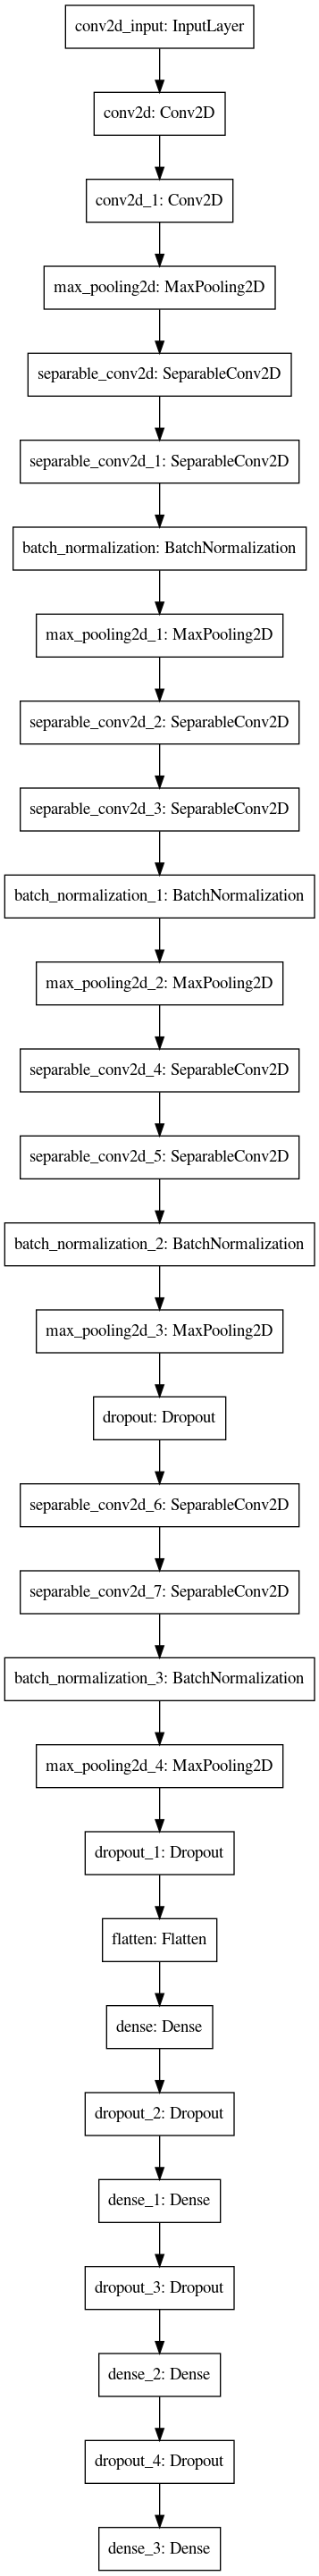

In [14]:
plot_model(model)

# 3. Model Fitting
# 3.1. CNN Application

In [15]:
cnn = model.fit(train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
                epochs=PARAMS['epochs'], validation_data=test_gen, 
                validation_steps=test_gen.samples // PARAMS['batch_size'],
                callbacks=[checkpoint, lr_reduce])

Epoch 1/10
2608/2608 [==============================] - 1934s 741ms/step - loss: 0.6184 - accuracy: 0.7793 - val_loss: 0.2565 - val_accuracy: 0.9094
Epoch 2/10
2608/2608 [==============================] - 1938s 743ms/step - loss: 0.4029 - accuracy: 0.8692 - val_loss: 0.1293 - val_accuracy: 0.9615
Epoch 3/10
2608/2608 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8847
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2608/2608 [==============================] - 1946s 746ms/step - loss: 0.3563 - accuracy: 0.8847 - val_loss: 0.1154 - val_accuracy: 0.9719
Epoch 4/10
2608/2608 [==============================] - 1942s 744ms/step - loss: 0.2777 - accuracy: 0.9108 - val_loss: 0.0593 - val_accuracy: 0.9865
Epoch 5/10
2608/2608 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9170
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
2608/2608 [==============================] - 1939s 744ms/st

We see that the model is able to reach more than 99% validation accuracy in just 9 epochs.

# 4. Model Evaluation 

In [16]:
print ('Train Accuracy:', np.mean(cnn.history['accuracy']))
print ('Train Loss:', np.mean(cnn.history['loss']))
print ('Test Accuracy:', np.mean(cnn.history['val_accuracy']))
print ('Test Loss:', np.mean(cnn.history['val_loss']))

Train Accuracy 0.8998058795928955
Train Loss 0.30291890650987624
Test Accuracy 0.9762500047683715
Test Loss 0.08170525655150414


# 4.1. Accuracy Plots

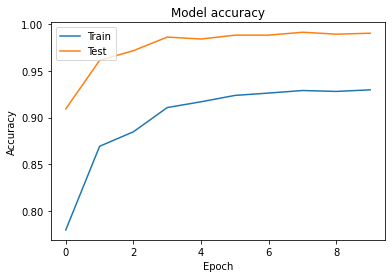

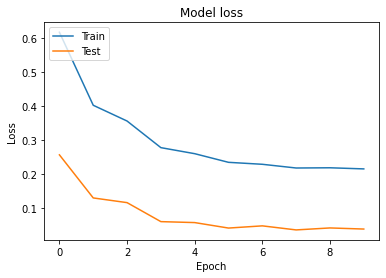

In [17]:
## Plot training & validation accuracy values
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
## Plot training & validation loss values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5. Interpretability
# 5.1. LIME Method

EXPLANATION RELATIVE TO FIRST IMAGE

In [18]:
explainer = lime_image.LimeImageExplainer(feature_selection='lasso_path')
explanation = explainer.explain_instance(X_test[1], model.predict_proba, top_labels=4, hide_color=0, num_samples=10000)

In [19]:
y = explanation.top_labels[0]
## Plot containing only the positive superpixels
#temp, mask = explanation.get_image_and_mask(y, positive_only=True, num_features=76800, hide_rest=True
## Pro and Cons plotting
#temp1, mask1 = explanation.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False)

## Creating the heatmap and finding some relevant percentiles measures
dict_heatmap = dict(explanation.local_exp[y])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
p_90 = np.percentile(heatmap, 90)
p_99 = np.percentile(heatmap, 99)
## We now try to highlight the superpixels with a weight in the explaination in the 90th percentile
temp2, mask2 = explanation.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_90)
## Now, instead we try to highlight the superpixels with a weight in the explaination in the 99th percentile
temp3, mask3 = explanation.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_99)

print(f"The image is predicted to belong to class: {y}")

The image is predicted to belong to class: 1


EXPLANATION RELATIVE TO SECOND IMAGE

In [27]:
explanation1 = explainer.explain_instance(X_test[33], model.predict_proba, top_labels=4, hide_color=0, num_samples=10000)

In [28]:
y = explanation1.top_labels[0]
## Plot containing only the positive superpixels
temp00, mask00 = explanation1.get_image_and_mask(y, positive_only=True, num_features=76800, hide_rest=True)
## Pro and Cons plotting
temp11, mask11 = explanation1.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False)

## Creating the heatmap and finding some relevant percentiles measures
dict_heatmap11 = dict(explanation1.local_exp[y])
heatmap11 = np.vectorize(dict_heatmap11.get)(explanation1.segments)
p_90 = np.percentile(heatmap11, 90)
p_99 = np.percentile(heatmap11, 99)
## We now try to highlight the superpixels with a weight in the explaination in the 90th percentile
temp22, mask22 = explanation1.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_90)
## Now, instead we try to highlight the superpixels with a weight in the explaination in the 99th percentile
temp33, mask33 = explanation1.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_99)

print(f"The image is predicted to belong to class: {y}")

The image is predicted to belong to class: 1


EXPLANATION RELATIVE TO THIRD IMAGE

In [48]:
explanation2 = explainer.explain_instance(X_test[211], model.predict_proba, top_labels=4, hide_color=0, num_samples=10000)

In [49]:
y = explanation2.top_labels[0]
## Plot containing only the positive superpixels
temp000, mask000 = explanation2.get_image_and_mask(y, positive_only=True, num_features=76800, hide_rest=True)
## Pro and Cons plotting
temp111, mask111 = explanation2.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False)

## Creating the heatmap and finding some relevant percentiles measures
dict_heatmap111 = dict(explanation2.local_exp[y])
heatmap111 = np.vectorize(dict_heatmap111.get)(explanation2.segments)
p_90 = np.percentile(heatmap111, 90)
p_99 = np.percentile(heatmap111, 99)
## We now try to highlight the superpixels with a weight in the explaination in the 90th percentile
temp222, mask222 = explanation2.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_90)
## Now, instead we try to highlight the superpixels with a weight in the explaination in the 99th percentile
temp333, mask333 = explanation2.get_image_and_mask(y, positive_only=False, num_features=76800, hide_rest=False, min_weight=p_99)

print(f"The image is predicted to belong to class: {y}")

The image is predicted to belong to class: 2


# 5.2. Visual Explanation

In [50]:
def plot_heatmaps(x, y, z):
    fig = plt.figure(figsize=(16,16))

    plt.subplot(131)
    plt.title('Heatmap')
    plt.imshow(x, cmap = 'RdBu', vmin  = -x.max(), vmax = x.max())
    plt.colorbar(shrink=0.25)

    plt.subplot(132)
    plt.title('Heatmap')
    plt.imshow(y, cmap = 'RdBu', vmin  = -y.max(), vmax = y.max())
    plt.colorbar(shrink=0.25)

    plt.subplot(133)
    plt.title('Heatmap')
    plt.imshow(z, cmap = 'RdBu', vmin  = -z.max(), vmax = z.max())
    plt.colorbar(shrink=0.25)

    return plt.show()

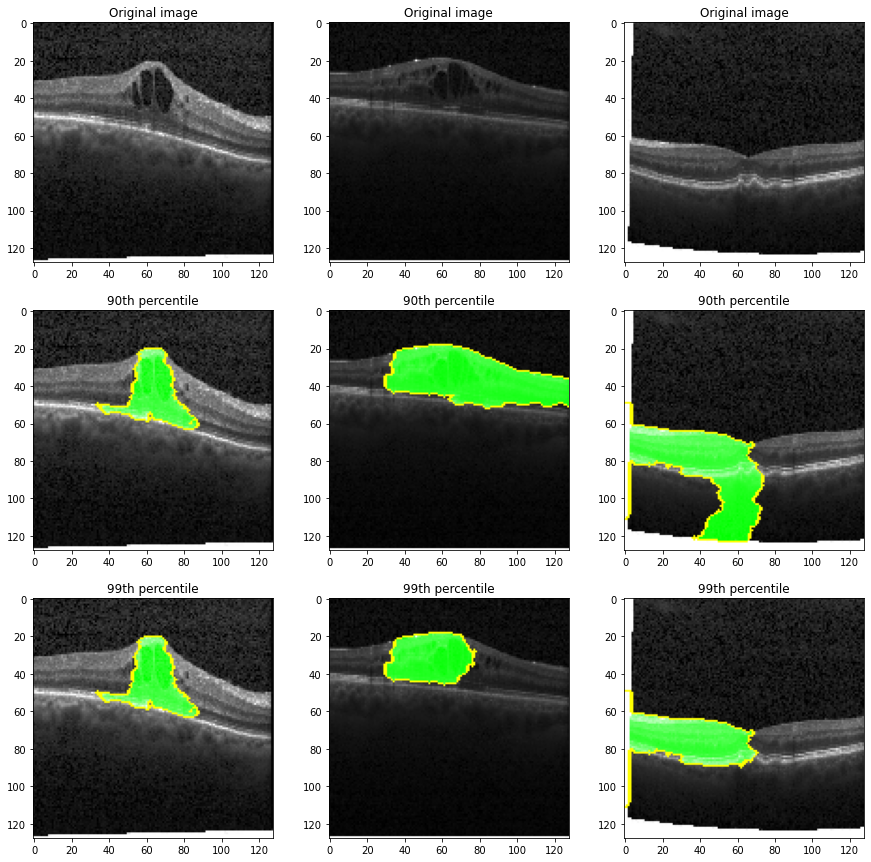

In [51]:
fig = plt.figure(figsize=(15,15))
## plt.subplot(abc) where: a # of rows, b # of columns & c is plot counter

###  subplot 1 ###
# CALL THE FUNCTION
plt.subplot(331)
plt.title('Original image')
plt.imshow(X_test[1],cmap='gray')
plt.subplot(334)
plt.title('90th percentile')
plt.imshow(mark_boundaries(temp2, mask2))
plt.subplot(337)
plt.title('99th percentile')
plt.imshow(mark_boundaries(temp3, mask3))

###  subplot 2 ###
# CALL THE FUNCTION
plt.subplot(332)
plt.title('Original image')
plt.imshow(X_test[33],cmap='gray')
plt.subplot(335)
plt.title('90th percentile')
plt.imshow(mark_boundaries(temp22, mask22))
plt.subplot(338)
plt.title('99th percentile')
plt.imshow(mark_boundaries(temp33, mask33))

###  subplot 3 ###
# CALL THE FUNCTION
plt.subplot(333)
plt.title('Original image')
plt.imshow(X_test[211],cmap='gray')
plt.subplot(336)
plt.title('90th percentile')
plt.imshow(mark_boundaries(temp222, mask222))
plt.subplot(339)
plt.title('99th percentile')
plt.imshow(mark_boundaries(temp333, mask333))

plt.show()

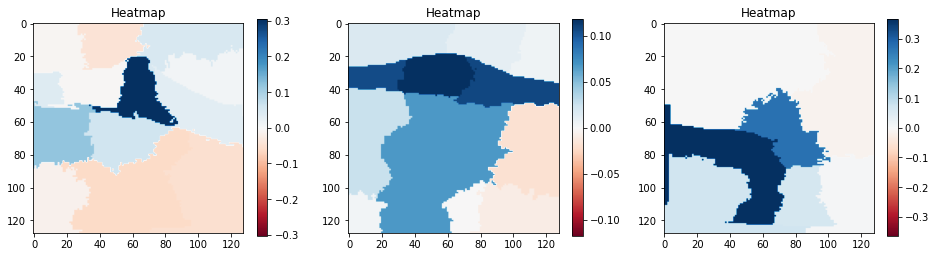

In [52]:
plot_heatmaps(heatmap, heatmap11, heatmap111)